We will make use of five datasets obtained from [GRID3 Nigeria](https://grid3.gov.ng/), an arm of a global initiative which aims to improve access to data for decision making in all participating countries.


The five datasets are;

1.   Built-up Areas - Built-up Areas (BUA) are Settlements with 100 buildings or more having accessibilities to modern facilities. 
2.   Lagos Settlements Points - Populated place (point) data with consistent population estimates.
3. Lagos Government Buildings - Building that houses a branch of government; in which the business of a department of government administration is carried out.
4. Lagos Factories/Industrial Sites - An industrial site, usually consisting of buildings and machinery, or more commonly a complex having several buildings, where workers manufacture goods or operate machines processing one product into another.
5. Lagos Tertiary Schools - Postsecondary education e.g universities, trade schools, polytechnic, monotechnic, colleges.


The features that are consistent across all the five datasets (which can also qualify as the target variables) are **LGA_name** and **ward_name**.

Using the **LGA_name** variable as our target variable would too ambiguous for our purpose, as 37 LGAs don't quite depict/represent the many towns in Lagos state. 

We feel that the **ward_name** variable would serve our purpose of predicting the nearest hot-locations way better.



In [0]:
!pip install geopandas
!pip install geojsonio

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

In [0]:
# importing the needed libraries for EDA
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, Point

# read the Lagos Built-up areas geospatial data
df = gpd.read_file("/content/drive/My Drive/GIS datasets/built-up-areas.geojson", index_col=0)
df.sample(3).T


,181,28,62
id,402760,403039,403059
name,Ayetejuu Town,Layeni-Okoya,6th Avenue Festac Town
ward_code,LASIUI02,LASATO10,LASAMO27
source,ORNL_08_2017,ORNL_08_2017,ORNL_08_2017
timestamp,2018-11-21T03:02:08,2019-02-03T10:32:45,2018-07-26T14:56:20
global_id,029c38c6-c99b-450d-aa99-63f94cf47b1f,d314657d-2130-4a33-82c2-6c9f88e27aa5,ff51b856-f1d7-47d7-bd65-7b0a38a726f2
object_id,BUA_LASIUI02_402760,BUA_LASATO10_403039,BUA_LASAMO27_403059
calculated_name,Ayetejuu Town,Layeni-Okoya,6th Avenue Festac Town
nb_denominator,NaN,NaN,NaN
weight,NaN,NaN,NaN


In [0]:
# Selecting the needed features
features = ["ward_name", "geometry"]
df = df[features]
df.sample(3)

,ward_name,geometry
202,Ifako Pele,"MULTIPOLYGON (((3.32330 6.64710, 3.32330 6.647..."
97,Alafia,"MULTIPOLYGON (((3.34500 6.47830, 3.34520 6.478..."
396,Bajulaiye,"MULTIPOLYGON (((3.38340 6.53370, 3.38420 6.532..."


In [0]:
# looking for missing values (Just protocol. Wasn't expecting any in the selected features, though)
df.isnull().sum()

ward_name    0
geometry     0
dtype: int64

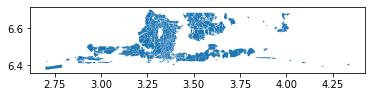

In [0]:
# Plotting a map of Lagos' built up areas locations
df.plot()

In [0]:
# Including a feature containing the centroid of the locations.
df['centroid'] = df.centroid
df.sample(3)

,ward_name,geometry,centroid
109,Ajara Topa,"MULTIPOLYGON (((2.85970 6.44300, 2.86070 6.443...",POINT (2.86234 6.44123)
1,Awori Oniwaya,"MULTIPOLYGON (((3.32080 6.61800, 3.32020 6.617...",POINT (3.31644 6.62082)
435,Adekunle/Aiyetoro,"MULTIPOLYGON (((3.37830 6.49370, 3.38130 6.494...",POINT (3.38269 6.49341)


In [0]:
# Obtaining the Multipolygon geometry bounds
df[['lat_min', 'long_min', 'lat_max', 'long_max']] = df.geometry.bounds
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475
ward_name,Atobaje,Awori Oniwaya,Awori Oniwaya,Dopemu,Isale Odo/Ayige,Isale Oja,Keke,Keke,Okekoto,Okekoto,Orile,Orile,Oyewole/Alaagba,Papa Ashafa,Papa Ashafa,Papa Uku/ Olusanya,Powerline/Oko-Oba,Powerline/Oko-Oba,Sango,Aiyetoro,Ajegunle,Alaba,Alakoto/Ibafon,Amukoko,Apasa Amukoko,Awodi-Ora,Bale Alayabiagba,Ibafon,Layeni-Okoya,Ojora Amukoko,Oke Oja,Oke Oja,Oluwa/Akere,Owoyemi,Temidire,Tolu,Abaranje/Okerube,Abesan 1,Abesan 2,Aboru,...,Aderupoko/Ijebu Qters,Alagomeji,Aloba/Desalu,Araromi,Botanical Garden,Freeman/Glover,Harvey,Iponri/Olaleye,Makoko,Ojo-Oniyun,Okobaba,Onike/Oyadiran,Otto,Oyingbo,Salami/ Baiyewunmi,Ajele,Alagba/Obadina,Anikantamo,Araromi Odo,Balogun,Epetedo East,Epetedo West,Idumoyingbo,Idunganran/Idumagbo,Ilupesi/Ebute Awo,Isale Gangan,Lafiaji,Lafiaji,Odam,Odam,Oke-Arin/Idumota,Oke-Arin/Idumota,Oke-Olowogbowo,Okepopo East,Okepopo East,Okepopo West,Okepopo West,Oko-Awo/Agarawu,Olosun/Ojo Oto,Oluwole
geometry,"(POLYGON ((3.3195 6.6235, 3.3195 6.6235, 3.319...","(POLYGON ((3.3208 6.618, 3.3202 6.6175, 3.3195...","(POLYGON ((3.3128 6.6165, 3.3131 6.6177, 3.313...","(POLYGON ((3.3299 6.6099, 3.3315 6.6059, 3.332...","(POLYGON ((3.3041 6.6343, 3.3062 6.6332, 3.306...","(POLYGON ((3.3253 6.6207, 3.3271 6.6163, 3.327...","(POLYGON ((3.3261 6.6288, 3.3287 6.6287, 3.328...","(POLYGON ((3.3254 6.6226, 3.3305 6.627, 3.335 ...","(POLYGON ((3.3188 6.6237, 3.3178 6.6243, 3.317...","(POLYGON ((3.3119 6.6267, 3.311 6.6282, 3.3106...","(POLYGON ((3.3104 6.6482, 3.3123 6.6483, 3.312...","(POLYGON ((3.3065 6.6477, 3.3103 6.648, 3.3114...","(POLYGON ((3.3011 6.6196, 3.3011 6.6196, 3.301...","(POLYGON ((3.313 6.6243, 3.3128 6.6236, 3.3128...","(POLYGON ((3.3095 6.6258, 3.31 6.6244, 3.3105 ...","(POLYGON ((3.3202 6.6206, 3.3201 6.6213, 3.320...","(POLYGON ((3.3166 6.6431, 3.314 6.6434, 3.3141...","(POLYGON ((3.3131 6.6393, 3.3138 6.6423, 3.314...","(POLYGON ((3.3246 6.6282, 3.3247 6.6242, 3.324...","(POLYGON ((3.3449 6.4629, 3.3479 6.463, 3.3484...","(POLYGON ((3.3362 6.4568, 3.3364 6.4568, 3.337...","(POLYGON ((3.3371 6.4656, 3.339 6.4661, 3.3405...","(POLYGON ((3.334 6.4468, 3.3346 6.4469, 3.335 ...","(POLYGON ((3.3535 6.4665, 3.3548 6.4665, 3.354...","(POLYGON ((3.3391 6.4691, 3.3389 6.4669, 3.340...","(POLYGON ((3.3359 6.4568, 3.3361 6.4562, 3.336...","(POLYGON ((3.3561 6.4552, 3.3531 6.4551, 3.351...","(POLYGON ((3.3333 6.4482, 3.3338 6.4482, 3.333...","(POLYGON ((3.3363 6.4584, 3.3363 6.4591, 3.336...","(POLYGON ((3.3391 6.4692, 3.3389 6.4692, 3.338...","(POLYGON ((3.3452 6.4708, 3.346 6.4704, 3.3481...","(POLYGON ((3.3513 6.4673, 3.3521 6.4672, 3.352...","(POLYGON ((3.3503 6.4527, 3.3504 6.4527, 3.350...","(POLYGON ((3.328 6.4666, 3.3287 6.4662, 3.3294...","(POLYGON ((3.3412 6.4381, 3.3415 6.4403, 3.341...","(POLYGON ((3.3485 6.4368, 3.3478 6.4385, 3.347...","(POLYGON ((3.2379 6.52, 3.2364 6.5188, 3.2327 ...","(POLYGON ((3.264 6.6063, 3.264 6.6063, 3.2639 ...","(POLYGON ((3.2623 6.6124, 3.2624 6.6167, 3.262...","(POLYGON ((3.2658 6.6198, 3.2667 6.6224, 3.266...",...,"(POLYGON ((3.3924 6.497, 3.3918 6.4978, 3.3915...","(POLYGON ((3.3762 6.499, 3.3784 6.4998, 3.3774...","(POLYGON ((3.3663 6.485, 3.3667 6.4855, 3.3672...","(POLYGON ((3.3866 6.484, 3.3893 6.4852, 3.3897...","(POLYGON ((3.376 6.4753, 3.3701 6.48, 3.3692 6...","(POLYGON ((3.3799 6.4903, 3.3823 6.4912, 3.383...","(POLYGON ((3.3761 6.4992, 3.3725 6.5079, 3.372...","(POLYGON ((3.3642 6.4875, 3.3633 6.49, 3.3654 ...","(POLYGON ((3.3851 6.4964, 3.3845 6.4984, 3.384...","(POLYGON ((3.3735 6.4887, 3.3738 6.4887, 3.375...","(POLYGON ((3.3893 6.4852, 3.3875 6.4845, 3.385...","(POLYGON ((3.3812 6.5048, 3.3814 6.5053, 3.378...","(POLYGON ((3.3764 6.4741, 3.3768 6.4742, 3.377...","(POLYGON ((3.383 6.4823, 3.3865 6

In [0]:
# Getting the count of the built_up_areas in each ward
df_count = df.groupby('ward_name').size().reset_index()
df_count

,ward_name,0
0,1004/Aboyade,1
1,Abaranje/Okerube,1
2,Abesan 1,1
3,Abesan 2,1
4,Abete,1
...,...,...
357,Tolu,1
358,Tonabu/Opopo,2
359,Unity Estate,1
360,Victoria Island,1


The main issue with Geospatial datasets is that they are usually more granular than what we usually need. Right now, we are exploring a dataset on the built-up areas in Lagos, even though what we need is the relationship and patterns at the state level.

For our purpose, we'd make use of the `dissolve` method to aggregrate our data. This works just like the familiar `groupby` method in Pandas, with the additional functionality of dissolving all the geometries within a given group together into a single geometric feature. 

Using the `dissolve` method, we transform our data from a built_up_area-level data to a ward-level data. We will do this alteration to all subsequent datasets.


In [0]:
df = df.dissolve('ward_name').reset_index()
df

,ward_name,geometry,centroid,lat_min,long_min,lat_max,long_max
0,1004/Aboyade,"POLYGON ((3.42400 6.43310, 3.42400 6.43310, 3....",POINT (3.43286 6.43638),3.4240,6.4321,3.4451,6.4409
1,Abaranje/Okerube,"POLYGON ((3.23790 6.52000, 3.23640 6.51880, 3....",POINT (3.24603 6.53249),3.2237,6.5183,3.2638,6.5527
2,Abesan 1,"POLYGON ((3.26400 6.60630, 3.26400 6.60630, 3....",POINT (3.26793 6.60728),3.2616,6.6039,3.2731,6.6100
3,Abesan 2,"POLYGON ((3.26230 6.61240, 3.26240 6.61670, 3....",POINT (3.26786 6.61454),3.2623,6.6104,3.2743,6.6191
4,Abete,"POLYGON ((3.35550 6.46660, 3.35560 6.46660, 3....",POINT (3.35763 6.46492),3.3555,6.4622,3.3606,6.4666
...,...,...,...,...,...,...,...
357,Tolu,"POLYGON ((3.34850 6.43680, 3.34780 6.43850, 3....",POINT (3.34812 6.44500),3.3449,6.4368,3.3513,6.4527
358,Tonabu/Opopo,"MULTIPOLYGON (((3.62490 6.59720, 3.62470 6.598...",POINT (3.64617 6.59284),3.6285,6.5658,3.6570,6.6198
359,Unity Estate,"POLYGON ((3.29450 6.58240, 3.29440 6.58130, 3....",POINT (3.28859 6.57749),3.2816,6.5708,3.2945,6.5859
360,Victoria Island,"POLYGON ((3.40900 6.43500, 3.40780 6.43780, 3....",POINT (3.41597 6.43094),3.4040,6.4221,3.4247,6.4416


In [0]:
# Including, as a feature, the number of the built_up_areas in each ward
df['BUA_count'] = df_count[0]
df

,ward_name,geometry,centroid,lat_min,long_min,lat_max,long_max,BUA_count
0,1004/Aboyade,"POLYGON ((3.42400 6.43310, 3.42400 6.43310, 3....",POINT (3.43286 6.43638),3.4240,6.4321,3.4451,6.4409,1
1,Abaranje/Okerube,"POLYGON ((3.23790 6.52000, 3.23640 6.51880, 3....",POINT (3.24603 6.53249),3.2237,6.5183,3.2638,6.5527,1
2,Abesan 1,"POLYGON ((3.26400 6.60630, 3.26400 6.60630, 3....",POINT (3.26793 6.60728),3.2616,6.6039,3.2731,6.6100,1
3,Abesan 2,"POLYGON ((3.26230 6.61240, 3.26240 6.61670, 3....",POINT (3.26786 6.61454),3.2623,6.6104,3.2743,6.6191,1
4,Abete,"POLYGON ((3.35550 6.46660, 3.35560 6.46660, 3....",POINT (3.35763 6.46492),3.3555,6.4622,3.3606,6.4666,1
...,...,...,...,...,...,...,...,...
357,Tolu,"POLYGON ((3.34850 6.43680, 3.34780 6.43850, 3....",POINT (3.34812 6.44500),3.3449,6.4368,3.3513,6.4527,1
358,Tonabu/Opopo,"MULTIPOLYGON (((3.62490 6.59720, 3.62470 6.598...",POINT (3.64617 6.59284),3.6285,6.5658,3.6570,6.6198,2
359,Unity Estate,"POLYGON ((3.29450 6.58240, 3.29440 6.58130, 3....",POINT (3.28859 6.57749),3.2816,6.5708,3.2945,6.5859,1
360,Victoria Island,"POLYGON ((3.40900 6.43500, 3.40780 6.43780, 3....",POINT (3.41597 6.43094),3.4040,6.4221,3.4247,6.4416,1


In [0]:
# Reading the Lagos Settlement Points geospatial dataset
settlement_points = gpd.read_file("/content/drive/My Drive/GIS datasets/settlement-points.geojson")
settlement_points.head(3).T

,0,1,2
id,sv_fc_settlementpt.fid--3786de59_16f63bee3bb_-...,sv_fc_settlementpt.fid--3786de59_16f63bee3bb_-...,sv_fc_settlementpt.fid--3786de59_16f63bee3bb_-...
geometry_type,POINT,POINT,POINT
latitude,6.62511,6.61446,6.618
longitude,3.32176,3.31278,3.32028
global_id,f67c2e71-cbc7-4b3c-9c69-2889051c9f11,d59cc6df-ac2c-473f-86b2-efc75a9717bf,acc24ad3-0971-437f-aeff-f2e8ce81bb5b
name,Okekoto,Dopemu,Oniwaya
alternate_name,None,None,None
ward_code,LASAGG01,LASAGG02,LASAGG02
source,ORNL_08_2017,GRID,GRID
ward_name,Atobaje,Awori Oniwaya,Awori Oniwaya


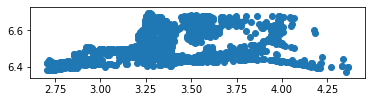

In [0]:
settlement_points.plot()

In [0]:
# Getting the number of settlement points per ward(that's all we need).

settlement_points_count = settlement_points.groupby('ward_name').size().reset_index()

settlement_points_count.rename(columns={0: 'settlement_points_count'}, inplace=True)
settlement_points_count

,ward_name,settlement_points_count
0,1004/Aboyade,2
1,Abaranje/Okerube,5
2,Abesan 1,6
3,Abesan 2,44
4,Abete,1
...,...,...
368,Topo-Idale,9
369,Unity Estate,2
370,Victoria Island,2
371,Wasimi,2


Officially, there are 377 wards in Lagos state.

We'd see here that we have a number of 362 wards in the Built-up areas data while we have a number of 373 wards in the Settlement points data, giving us a difference of 11 wards!

This implies that even though there are settlement points in almost all wards in Lagos, not all those wards are fully developed communities.

In [0]:
# Merging the BUA and Settlement Points data together
df = df.merge(settlement_points_count, on='ward_name', how='outer')
df

,ward_name,geometry,centroid,lat_min,long_min,lat_max,long_max,BUA_count,settlement_points_count
0,1004/Aboyade,"POLYGON ((3.42400 6.43310, 3.42400 6.43310, 3....",POINT (3.43286 6.43638),3.4240,6.4321,3.4451,6.4409,1.0,2
1,Abaranje/Okerube,"POLYGON ((3.23790 6.52000, 3.23640 6.51880, 3....",POINT (3.24603 6.53249),3.2237,6.5183,3.2638,6.5527,1.0,5
2,Abesan 1,"POLYGON ((3.26400 6.60630, 3.26400 6.60630, 3....",POINT (3.26793 6.60728),3.2616,6.6039,3.2731,6.6100,1.0,6
3,Abesan 2,"POLYGON ((3.26230 6.61240, 3.26240 6.61670, 3....",POINT (3.26786 6.61454),3.2623,6.6104,3.2743,6.6191,1.0,44
4,Abete,"POLYGON ((3.35550 6.46660, 3.35560 6.46660, 3....",POINT (3.35763 6.46492),3.3555,6.4622,3.3606,6.4666,1.0,1
...,...,...,...,...,...,...,...,...,...
368,Owu/Ota,None,None,NaN,NaN,NaN,NaN,NaN,4
369,Siriwon/ Igbekodo 1,None,None,NaN,NaN,NaN,NaN,NaN,3
370,Taffi,None,None,NaN,NaN,NaN,NaN,NaN,2
371,Topo-Idale,None,None,NaN,NaN,NaN,NaN,NaN,9


In [0]:
# Reading the Factories/Industrial sites data
industrial_sites = gpd.read_file("/content/drive/My Drive/GIS datasets/factoriesindustrial-sites.geojson")
industrial_sites.head(5).T

,0,1,2,3,4
id,sv_fc_poi_factory_industry_site.fid--3786de59_...,sv_fc_poi_factory_industry_site.fid--3786de59_...,sv_fc_poi_factory_industry_site.fid--3786de59_...,sv_fc_poi_factory_industry_site.fid--3786de59_...,sv_fc_poi_factory_industry_site.fid--3786de59_...
geometry_type,POINT,POINT,POINT,POINT,POINT
latitude,6.44437,6.46385,6.45273,6.46131,6.46991
longitude,3.33508,3.33291,3.32939,3.3388,3.35057
global_id,51fdfea1-668e-4726-b485-3be233c08e9b,8b6de029-fa53-4dd7-8cbd-cd5e869f9d49,35619d68-1bdb-4e39-ac02-bb1f4c61ec37,103ce055-af24-4871-8bc8-a852a492ed24,bda75de4-eaf1-48fe-ba87-55d2eb416a33
name,Pharmexco Pharmaceutical Ltd,Coca Cola,Bakery,Oloyin Table Water,Halogen Protected
status,In Use,In Use,In Use,In Use,In Use
ward_code,LASATO04,LASATO06,LASATO07,LASATO10,LASATO12
source,GRID,GRID,GRID,GRID,GRID
ward_name,Alakoto/Ibafon,Apasa Amukoko,Awodi-Ora,Layeni-Okoya,Oke Oja


Since we are only interested in the number of factories that are present in each ward, I'll extract out the numbers and discard the rest.


In [0]:
industrial_sites_count = industrial_sites.groupby('ward_name').size().reset_index()
industrial_sites_count.rename(columns={0: 'industrial_sites_count'}, inplace=True)

# Merge the numbers with the dataset
df = df.merge(industrial_sites_count, on='ward_name', how='outer')

# Filling in missing values (for the wards where we don't have factories)
df.industrial_sites_count = df.industrial_sites_count.fillna(0)
df.tail(3).T

,370,371,372
ward_name,Taffi,Topo-Idale,Wesere
geometry,None,None,None
centroid,None,None,None
lat_min,NaN,NaN,NaN
long_min,NaN,NaN,NaN
lat_max,NaN,NaN,NaN
long_max,NaN,NaN,NaN
BUA_count,NaN,NaN,NaN
settlement_points_count,2,9,6
industrial_sites_count,0,0,0


In [0]:
# Read the government buildings dataset and get the count in each ward

government_buildings = gpd.read_file("/content/drive/My Drive/GIS datasets/government-buildings.geojson")
gov_buildings_count = government_buildings.groupby('ward_name').size().reset_index()

gov_buildings_count.rename(columns={0: 'gov_buildings_count'}, inplace=True)
gov_buildings_count

,ward_name,gov_buildings_count
0,1004/Aboyade,1
1,Abete,1
2,Abosan,2
3,Abraham Adesanya,8
4,Abule Oja,1
...,...,...
165,Shitta Bank Olemoh,1
166,Tarkwa Bay,3
167,Temidire,3
168,Victoria Island,15


In [0]:
# Merging the gov buildings count with our main dataset

df = df.merge(gov_buildings_count, on='ward_name', how='outer')
df.gov_buildings_count = df.gov_buildings_count.fillna(0)
df.tail(3).T

,370,371,372
ward_name,Taffi,Topo-Idale,Wesere
geometry,None,None,None
centroid,None,None,None
lat_min,NaN,NaN,NaN
long_min,NaN,NaN,NaN
lat_max,NaN,NaN,NaN
long_max,NaN,NaN,NaN
BUA_count,NaN,NaN,NaN
settlement_points_count,2,9,6
industrial_sites_count,0,0,0


In [0]:
tertiary_schools = gpd.read_file("/content/drive/My Drive/GIS datasets/tertiary-schools.geojson")

tertiary_schools = tertiary_schools.groupby('ward_name').size().reset_index()
tertiary_schools.rename(columns={0: 'tertiary_schools_count'}, inplace=True)
tertiary_schools

,ward_name,tertiary_schools_count
0,Abosan,1
1,Abule Egba/Ilupeju,1
2,Abule Oja,4
3,Addo/Okeira,1
4,Ailegun,1
5,Aiyetoro,1
6,Ajah,1
7,Ajara Vetho,3
8,Amukoko,1
9,Anthony,1


In [0]:
#Merging the Tertiary Schools count with the main dataset

df = df.merge(tertiary_schools, on='ward_name', how='outer')
df.tertiary_schools_count = df.tertiary_schools_count.fillna(0)
df.tail(3).T

,370,371,372
ward_name,Taffi,Topo-Idale,Wesere
geometry,None,None,None
centroid,None,None,None
lat_min,NaN,NaN,NaN
long_min,NaN,NaN,NaN
lat_max,NaN,NaN,NaN
long_max,NaN,NaN,NaN
BUA_count,NaN,NaN,NaN
settlement_points_count,2,9,6
industrial_sites_count,0,0,0


In [0]:
# Getting the wards where we have missing values

df.loc[(df.geometry.isnull())].T

,362,363,364,365,366,367,368,369,370,371,372
ward_name,Ajebo Orugbo,Akoro,Ibonwon,Irewe,Lekki 2,Mayunre-Oriba/Orepete-Ito Omu,Owu/Ota,Siriwon/ Igbekodo 1,Taffi,Topo-Idale,Wesere
geometry,None,None,None,None,None,None,None,None,None,None,None
centroid,None,None,None,None,None,None,None,None,None,None,None
lat_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUA_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
settlement_points_count,10,9,2,4,11,15,4,3,2,9,6
industrial_sites_count,0,0,0,0,6,3,0,2,0,0,0


The above shows that we have 11 wards that aren't built-up areas. We can choose to merge them with the nearest wards. We could also just delete them, as they might contribute weeds to the data.

In [0]:
# Dropping wards that aren't built-up areas
bad_wards = df.loc[(df.geometry.isnull())].index
df.drop(bad_wards, inplace=True)

df.loc[(df.geometry.isnull())]

,ward_name,geometry,centroid,lat_min,long_min,lat_max,long_max,BUA_count,settlement_points_count,industrial_sites_count,gov_buildings_count,tertiary_schools_count


We are done with our Data Analysis and Exploration. Cheers!

What is left to do before we train our model is to drop the unneeded categorical data.

In [0]:
display(df.columns)
df.dtypes

Index(['ward_name', 'geometry', 'centroid', 'lat_min', 'long_min', 'lat_max',
       'long_max', 'BUA_count', 'settlement_points_count',
       'industrial_sites_count', 'gov_buildings_count',
       'tertiary_schools_count'],
      dtype='object')

ward_name                    object
geometry                   geometry
centroid                   geometry
lat_min                     float64
long_min                    float64
lat_max                     float64
long_max                    float64
BUA_count                   float64
settlement_points_count       int64
industrial_sites_count      float64
gov_buildings_count         float64
tertiary_schools_count      float64
dtype: object

In [0]:
df.drop(['geometry', 'centroid'], axis=1, inplace=True)
df.head(3).T

,0,1,2
ward_name,1004/Aboyade,Abaranje/Okerube,Abesan 1
lat_min,3.424,3.2237,3.2616
long_min,6.4321,6.5183,6.6039
lat_max,3.4451,3.2638,3.2731
long_max,6.4409,6.5527,6.61
BUA_count,1,1,1
settlement_points_count,2,5,6
industrial_sites_count,2,4,0
gov_buildings_count,1,0,0
tertiary_schools_count,0,0,0


# Model Training and Selection

We will make use of K-Nearest Neighbors, a model algorithm that is synonymous with Recommender Systems all over the globe.

In [0]:
df.head(3).T


,0,1,2
ward_name,1004/Aboyade,Abaranje/Okerube,Abesan 1
lat_min,3.424,3.2237,3.2616
long_min,6.4321,6.5183,6.6039
lat_max,3.4451,3.2638,3.2731
long_max,6.4409,6.5527,6.61
BUA_count,1,1,1
settlement_points_count,2,5,6
industrial_sites_count,2,4,0
gov_buildings_count,1,0,0
tertiary_schools_count,0,0,0


In [0]:
# Separating the target variable from the predictors
y = df.ward_name
X = df.drop(['ward_name'], axis=1)

Since our target variable contains unique ward names (each ward name will only appear once), we will have to use the whole of the dataset to train our model and get our testing data elsewhere.

We will get our testing data from the raw settlements points (Populated place (point) data with consistent population estimates) data.

In [0]:
print(list(settlement_points.name.unique()))

['Okekoto', 'Dopemu', 'Oniwaya', 'Morikaz', 'Old Ipaja', 'Egudu Baale', 'Mangoro', 'Atanda', 'Agege Bye Pass', 'Iloro', 'Isale Oja', 'Orile', 'Tabon Tabon', 'Oja Oba', 'Ijaiye Ifako', 'Oko Oba', 'Mulero', 'Agbotikuyo', 'Papa', 'Powerline', 'Agege', 'Moshalashi', 'Aiyetoro', 'Ajegunle', 'Mosafejo', 'Alakoto Ibafon', 'Amukoko', 'Awodi Ora', 'Ibafon', 'Layeni Okoya', 'Badia', 'Olodi Apapa', 'Alaba Oro', 'Temidire', 'Tolu', 'Irepo Estate', 'Arabanje', 'Okerube', 'Ikotun Igando', 'Abaranje', 'Section 1', 'Abule Egun', 'Niniola Street', 'Third Avenue', 'Majekodunmi', 'Sector 7', 'Cresh At Bale Amosu Street', 'Dabiri Close', 'Ashimolowo 5th Avenue', 'Anifowoshe Street Near Shilo', 'Four Square', 'Okin', 'David Street', 'Abosede Aro Street', 'Abiara', 'Jakunde Estate', 'Okedara Street 5th Avenue', 'Ellebell', 'Akinyele Estate', 'Shitta Aby', 'Avenue', 'Olusegun Otitoola Street', 'Cele', 'Ogundare', 'Falete Close', 'Awokoya Street Amosu', 'Unique', 'Animashaun Street', 'Abimbola Fagbo Street', 

In [0]:
# test_size = 1
# test_data = settlement_points.sample(test_size)
test_data = settlement_points.loc[(settlement_points.name == 'Ipaja')]
test_size = test_data.shape[0]
test_data.T

,150,211
id,sv_fc_settlementpt.fid--3786de59_16f63bee3bb_-...,sv_fc_settlementpt.fid--3786de59_16f63bee3bb_-...
geometry_type,POINT,POINT
latitude,6.59102,6.6134
longitude,3.21906,3.25583
global_id,d518a5b9-a942-4efe-a2d3-0d7d714ed621,9fa1b3c2-b268-4552-a30e-26d091c53f8d
name,Ipaja,Ipaja
alternate_name,None,None
ward_code,LASAMO15,LASAMO26
source,GRID,GRID
ward_name,Bada-Megida,Ipaja


In [0]:
# Preprocessing our test data

test_data = test_data[['name', 'geometry']]

# getting the lower and upper coordinates while dropping the geometry column
test_data[['lat_min', 'long_min', 'lat_max', 'long_max']] = test_data.geometry.bounds
test_data.drop('geometry', axis=1, inplace=True)

test_data.T

,150,211
name,Ipaja,Ipaja
lat_min,3.2191,3.2558
long_min,6.591,6.6134
lat_max,3.2191,3.2558
long_max,6.591,6.6134


In [0]:
# Initializing the other features (attributes that we feature engineered) to None

initial = [None for i in range(test_size)]
other_features = ['BUA_count', 'settlement_points_count', 'industrial_sites', 'gov_buildings_count', 'tertiary_schools_count']
for i in other_features:
  test_data[i] = initial

test_data.T

,150,211
name,Ipaja,Ipaja
lat_min,3.2191,3.2558
long_min,6.591,6.6134
lat_max,3.2191,3.2558
long_max,6.591,6.6134
BUA_count,None,None
settlement_points_count,None,None
industrial_sites,None,None
gov_buildings_count,None,None
tertiary_schools_count,None,None


The reason while we included those attributes that we feature-engineered in our test data and declare it as `None` is because our test data must have the same dimension (i.e. the same number of labels) as our training data.

If not, our model algorithm will throw up an error while predicting the nearest locations.

We will use Iterative Imputer from sklearn to impute the labels that we declared as `None`.

In [0]:
# Splitting our test data into target variable and labels

test = test_data.drop('name', axis=1)
y_test = test_data['name']

In [0]:
# Using Iterative Imputer to impute the initialized features.

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_estimator = ExtraTreesRegressor(n_estimators=100, random_state=0)
imp = IterativeImputer(max_iter=500, random_state=0, estimator=impute_estimator)
imp.fit(X)

X_test = gpd.GeoDataFrame(imp.transform(test))
X_test.columns = test.columns

X_test.T


,0,1
lat_min,3.2191,3.2558
long_min,6.5910,6.6134
lat_max,3.2191,3.2558
long_max,6.5910,6.6134
BUA_count,1.3000,1.8000
settlement_points_count,5.4800,9.3000
industrial_sites,3.0400,3.5400
gov_buildings_count,1.0600,2.0500
tertiary_schools_count,0.1800,0.1600


Normalization helps change the values of numeric features to a common scale, without distorting differences in the range of values or losing information. 

Normalization is very important for distance-based models (e.g. KNN).

We'd make use of StandardScaler.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [0]:
# Building our model

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, y)

# Getting our nearest locations
clf.kneighbors(X_test)

(array([[0.91855155, 0.97186497, 1.0092444 ],
        [1.41956805, 1.45798125, 1.48909763]]), array([[199,  93, 122],
        [199, 244, 114]]))

As you can see, there are 2 arrays as output. The first array represent the distances between the present location and the nearest locations (KNN makes use of the Euclidean distance as a default). 

While the 2nd represent the indexes of the nearest locations.

Our next line of code gives us the indexes only.

In [0]:
nearest_locations = clf.kneighbors(X_test, return_distance=False)
nearest_locations

array([[199,  93, 122],
       [199, 244, 114]])

Now we see the names of our nearest locations;

In [0]:
for i in range(test_size):
  print("Current_location ==> ", y_test.iloc[i])
  print("Nearest Hotzones ==> ")
  print(df.loc[(nearest_locations[i]), 'ward_name'])
  print(".....\n.....")

Current_location ==>  Ipaja
Nearest Hotzones ==> 
199         Ipaja
93     Atan Lagos
122        Egbeda
Name: ward_name, dtype: object
.....
.....
Current_location ==>  Ipaja
Nearest Hotzones ==> 
199              Ipaja
244    Mosan/Akinoggun
114             Baruwa
Name: ward_name, dtype: object
.....
.....
